### Importing necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from tensorflow import keras

from keras.layers import Input, Conv2D, Dense, AveragePooling2D, MaxPooling2D, Reshape, Flatten, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.models import Model, save_model, load_model
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, array_to_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2

import os
from time import time

Using TensorFlow backend.


### Creating function that allows to load datasets

In [2]:
direct = '/home/adam/Pulpit/jupyter_notebook/algorytmy_maszynowe/projekty/Histopathologic_cancer_detection/cell_images'

categories = ['Parasitized', 'Uninfected']

In [3]:
data = []

def create_training_data():
    

    categories = ['Parasitized', 'Uninfected']
    
    for category in categories:
        path = os.path.join(direct, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (66, 66))
                data.append([new_array, class_num])
            except Exception as e:
                pass

In [4]:
create_training_data()

### Dividing data into features and labels

In [5]:
X = []
y = []

for img, label in data:
        X.append(img.astype('float32')/255.)
        y.append(label)

X = np.array(X).reshape(-1, 66, 66, 3)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

### Visualizing some samples to analyse problem

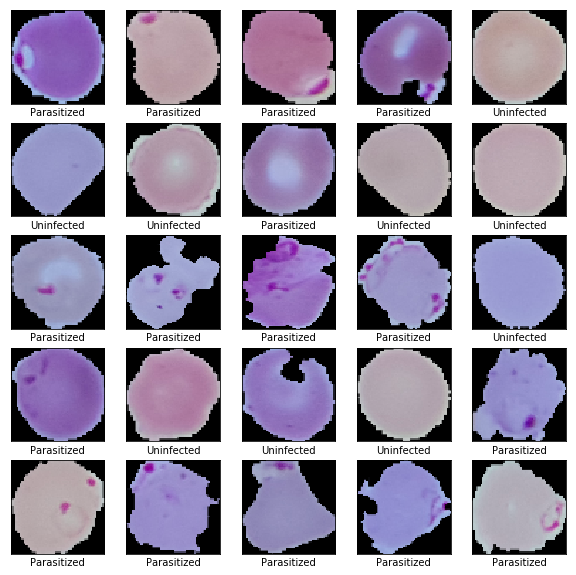

In [7]:
plt.figure(figsize = (10, 10))

for i in range(1, 26, 1):
    plt.subplot(5, 5, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap = plt.cm.binary)
    plt.xlabel(categories[y_train[i]])
plt.show()

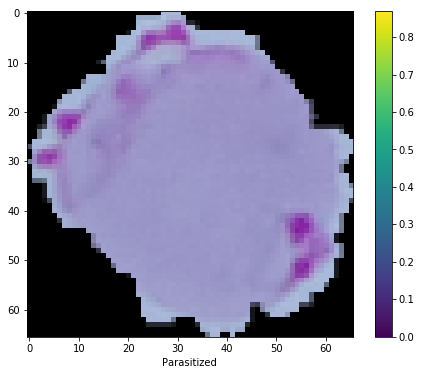

In [25]:
plt.figure(figsize = (8, 6))
plt.imshow(X_train[14])
plt.xlabel(categories[y_train[14]])
plt.colorbar()
plt.grid(False)
plt.show()

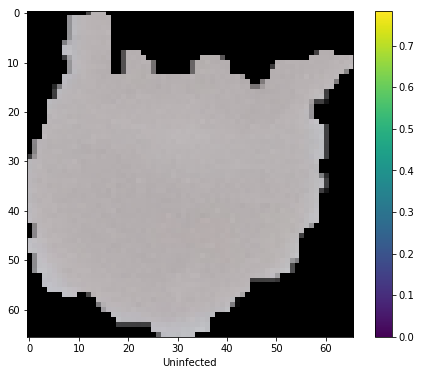

In [12]:
plt.figure(figsize = (8, 6))
plt.imshow(X_train[0])
plt.xlabel(categories[y_train[0]])
plt.colorbar()
plt.grid(False)
plt.show()

### Creating image data generators to avoid problem with overfitting

In [26]:
train_datagen = ImageDataGenerator(rotation_range = 20, shear_range = 0.1, zoom_range = 0.2,
                                   horizontal_flip = True, vertical_flip = True,
                                   fill_mode = 'nearest', validation_split = 0.2)

test_datagen = ImageDataGenerator()

### Random effects of augmentation

In [27]:
img= load_img(path = '/home/adam/Pulpit/jupyter_notebook/algorytmy_maszynowe/projekty/Histopathologic_cancer_detection/cell_images/Parasitized/C46P7ThinF_IMG_20151130_210938_cell_169.png',
                    target_size = (66, 66))

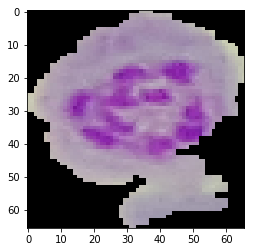

In [28]:
plt.imshow(img)
plt.show()

In [29]:
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

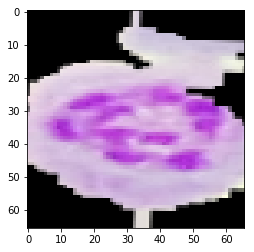

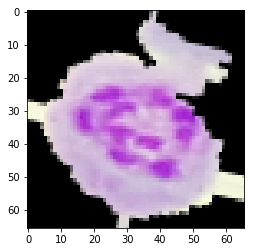

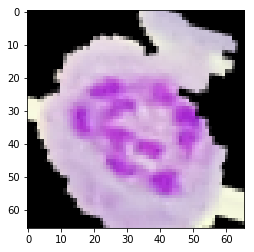

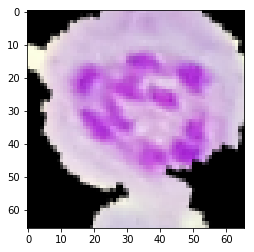

In [30]:
i = 0 
for batch in train_datagen.flow(x, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

### Defining datasets coming from generators

In [31]:
train_generator = train_datagen.flow(X_train, y_train, batch_size = 32, subset = 'training')

In [32]:
validation_generator = train_datagen.flow(X_train, y_train, batch_size = 32, subset = 'validation')

In [33]:
test_generator = test_datagen.flow(X_test, y_test, batch_size = 32, shuffle = False)

### Choosing Adam optimalizator

In [34]:
adam_opt = Adam(lr = 0.0001)

### Creating convolutional model and compiling it

In [35]:
def create_model():

    inp = Input(shape = (66, 66, 3))
    
    x = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'valid', activation = 'relu',
          kernel_initializer = 'he_normal', data_format='channels_last')(inp)
    x = AveragePooling2D(pool_size = (2, 2), padding = 'valid')(x)
    
    x = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'valid', activation = 'relu',
          kernel_initializer = 'he_normal')(x)
    x = AveragePooling2D(pool_size = (2, 2), padding = 'valid')(x)
    x = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'valid', activation = 'relu',
          kernel_initializer = 'he_normal')(x)
    
    x = Flatten()(x)
    x = Dense(128, kernel_initializer= 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(128, activation = 'relu', kernel_initializer= 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
  
    output = Dense(1, activation = 'sigmoid', kernel_initializer= 'he_normal')(x)
    
    model = Model(inputs = inp, outputs = output)
    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [36]:
model = create_model()

### Defining callbacks

In [37]:
checkpoint = ModelCheckpoint(filepath = './modele/model'.format(int(time())), monitor = 'val_acc', 
                                           save_best_only = True, mode = 'max')

tensorboard = TensorBoard(log_dir='./graphs/graph'.format(int(time())), histogram_freq= 0, 
                                          write_graph= True, write_images = True, batch_size = 50)

earlystopping = EarlyStopping(monitor = 'val_acc', mode = 'max', patience = 6)

### Training model

In [38]:
history = model.fit_generator(train_generator, steps_per_epoch = 603, epochs = 30, shuffle = True,
                               callbacks = [checkpoint, tensorboard, earlystopping],
                             validation_data = validation_generator, validation_steps = 130)

Epoch 1/30
603/603 [==============================] - 204s 338ms/step - loss: 0.6380 - acc: 0.6584 - val_loss: 1.3750 - val_acc: 0.5200
Epoch 2/30
603/603 [==============================] - 203s 336ms/step - loss: 0.5436 - acc: 0.7336 - val_loss: 0.6603 - val_acc: 0.5948
Epoch 3/30
603/603 [==============================] - 222s 368ms/step - loss: 0.3217 - acc: 0.8756 - val_loss: 0.4145 - val_acc: 0.9032
Epoch 4/30
603/603 [==============================] - 225s 373ms/step - loss: 0.2377 - acc: 0.9198 - val_loss: 0.2915 - val_acc: 0.9160
Epoch 5/30
603/603 [==============================] - 204s 339ms/step - loss: 0.2114 - acc: 0.9319 - val_loss: 0.1884 - val_acc: 0.9388
Epoch 6/30
603/603 [==============================] - 205s 340ms/step - loss: 0.2047 - acc: 0.9333 - val_loss: 0.2055 - val_acc: 0.9367
Epoch 7/30
603/603 [==============================] - 205s 340ms/step - loss: 0.1888 - acc: 0.9388 - val_loss: 0.1641 - val_acc: 0.9509
Epoch 8/30
603/603 [============================

### Evaluating trained model

In [39]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps = 173)

In [40]:
print('Test loss: %4.2f' % (test_loss))
print('Test accuracy: %4.2f' % (test_accuracy))

Test loss: 0.11
Test accuracy: 0.97


### Plotting history to analyse training stage

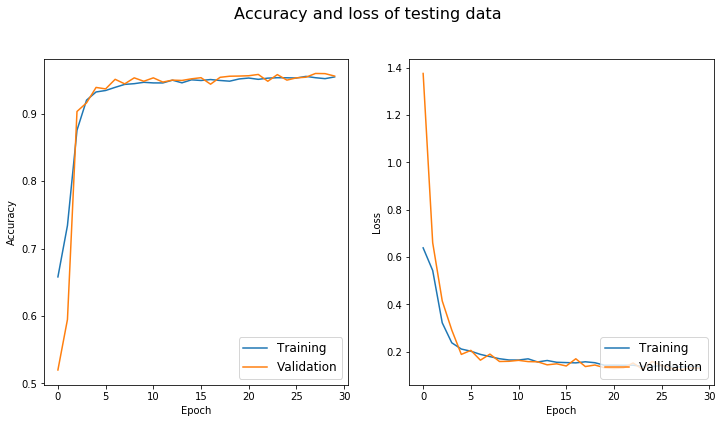

In [41]:
plt.figure(figsize = (12, 6))

plt.subplot(121)
plt.plot(history.history['acc'], label = 'Training')
plt.plot(history.history['val_acc'], label = 'Validation')
plt.legend(loc = 'lower right', fontsize = 12)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = "Vallidation")
plt.legend(loc = 'lower right', fontsize = 12)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.suptitle(t = 'Accuracy and loss of testing data', x = 0.5, y = 1, fontsize = 16)
plt.show()

### Saving trained model

In [42]:
# save_model(model, './final_model')

### Loading saved model 

In [7]:
# model = load_model('./final_model')

### Plotting confusion matrix and classification report 

In [43]:
y_pred = model.predict(X_test)

In [44]:
y_pred = 1*(y_pred >= 0.5)

In [45]:
cm = confusion_matrix(y_test, y_pred)

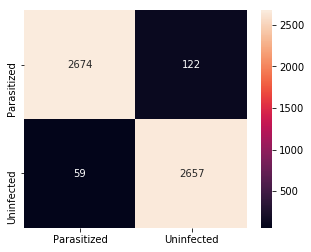

In [46]:
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (5, 4))
sn.heatmap(df_cm, annot=True, fmt='g', xticklabels= ["Parasitized", "Uninfected"], yticklabels= ["Parasitized", "Uninfected"])
plt.show()

In [47]:
print(classification_report(y_test, y_pred, target_names=["Paraistized", "Uninfected"]))

              precision    recall  f1-score   support

 Paraistized       0.98      0.96      0.97      2796
  Uninfected       0.96      0.98      0.97      2716

   micro avg       0.97      0.97      0.97      5512
   macro avg       0.97      0.97      0.97      5512
weighted avg       0.97      0.97      0.97      5512



### Final accuracy score 

In [48]:
print(accuracy_score(y_test, y_pred))

0.9671625544267054


### Plotting predictions 

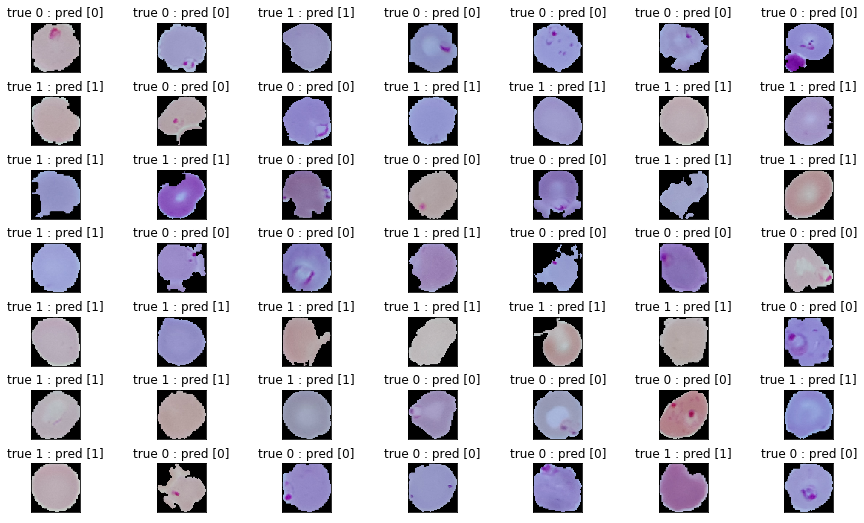

In [49]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , X_test.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(X_test[r[0]])
    plt.title('true {} : pred {}'.format(y_test[r[0]] , y_pred[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()